In [4]:
import gc
import glob
import os
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input

%matplotlib inline

# 【問題1】コードレビュー
転移学習を使用してセグメンテーションの精度を改善したコードを提示するので、レビューを行ってください。
《視点例》  
前回使用した実装とはどのように違うのか  
転移学習をどのように行っているか

# Unet_resnet

def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('activation_1').output
    encoder2 = base_model.get_layer('activation_10').output
    encoder3 = base_model.get_layer('activation_22').output
    encoder4 = base_model.get_layer('activation_40').output
    encoder5 = base_model.get_layer('activation_49').output

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

# decoder_block_simple
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3)):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

 ## コードレビュー
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)

    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('activation_1').output
    encoder2 = base_model.get_layer('activation_10').output
    encoder3 = base_model.get_layer('activation_22').output
    encoder4 = base_model.get_layer('activation_40').output
    encoder5 = base_model.get_layer('activation_49').output

前回の実装では各レイヤーごとに指定していたが、今回転移学習をさせるためにresnet50を最初に指定している。 
引数としてinput_shape,include_top,weightsは指定されている  
input_shapeは入力画像のshape  
include_topは出力層の有無。今回はFalseなので出力層はない
weightsは転移学習をする際の初期の重み。  
今回は"imagenet"なのでImagenaetで学習した重みを使用している  
そのあと、デコーダーで結合させるレイヤーを取り出している

## コードレビュー
center = decoder_block(  
　　　　encoder5, 'center', num_filters=512)  
concat5 = concatenate([center, encoder5], axis=-1)  

U字の最下部の処理  
decoder_blockとは畳み込み→正規化→活性化関数という通常のCNNの処理を行なっている  
最下部で処理そしてpadding=sameでありmaxpoolをしていないのでshapeが変わらず処理されている  
さらに、デコーダ処理のconcatを行なっている  
その際結合するのは最下部で処理をしたcenterとbase_layerから取り出したencoder5の出力の特徴量マップである    

## コードレビュー
decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

デコーダ部分  
結合されたものをdecoder_blockで通常のCNN処理  
その後decoder_blockの出力をUpSampling2Dでアップサンプリング処理をして  
base_layerから取り出したencoderの出力を結合させている  
それをすべてのlayerで行なっている

## コードレビュー
output = UpSampling2D()(concat1)  
   
output = decoder_block(  
        output, 'decoder_output', num_filters=32)  
output = Conv2D(  
        1, (1, 1), activation=None, name='prediction')(output)
        
if not use_lovash:
　　　　output = Activation('sigmoid')(output)
   
出力層の作成  
  
最後のアップサンプリングをした後、CNN処理をして  
最後に畳み込み層を作成している  
最後の畳み込み層は出力クラス数を指定している。今回は二値分類なので１  
if文の前まででは恒等関数だが、if文後にsigmoidで二値の確率が入ったarrayを返している  

## コードレビュー
model = Model(base_model.input, output)
model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

 return model
 
最後にモデルを作成している  
kerasのModel関数を用いてモデルを作り  
コンパイルして、モデルを返している  
lossnには引数で渡してあるbinary_cross_entropyが使われている

## コードレビュー


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)
    
    
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric
    
metricsの計算
初期値ではmy_iou_metricがmetricsの計算で使われている  
my_iou_metricの中でget_iou_vectorが使用されている  
iouを計算し、その平均値を返している

# 【問題2】コードの書き換え
エンコーダーにResNetが使用されていたコードをVGGに変更してください。

In [7]:
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3)):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec
  
def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)
  
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric
  
def img2array(img_list):
    """
    パスから画像のarrayを取得
    """
    array = np.empty((0, 224,224, 1))
    i = 0
    for img in img_list:
        if i < 10:
            image = cv2.imread(img, 0)
            print(image.shape)
            image = cv2.resize(image, (224,224))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.reshape(1, 224,224,1)
            array = np.concatenate([array, image], axis=0)
    return array

def get_path_list(p):
    path = p
    img_list = glob.glob(path  + '/*' + ".png")
    return img_list

## resnet

In [8]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('activation_1').output
    encoder2 = base_model.get_layer('activation_10').output
    encoder3 = base_model.get_layer('activation_22').output
    encoder4 = base_model.get_layer('activation_40').output
    encoder5 = base_model.get_layer('activation_49').output

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

## VGGに変換

In [9]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_vgg(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_model = VGG16(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('block1_conv2').output
    encoder2 = base_model.get_layer('block2_conv2').output
    encoder3 = base_model.get_layer('block3_conv3').output
    encoder4 = base_model.get_layer('block4_conv3').output
    encoder5 = base_model.get_layer('block5_conv3').output

    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    
    concat5 = concatenate([center, encoder5], axis=-1)
    

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)
    

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)
    
    
    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)
    

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
   
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)
 

    # Final upsampling and decoder block for segmentation.
    #output = UpSampling2D()(concat1)
    output = decoder_block(
        concat1, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

# 【問題3】学習・推定
ResNetとVGG双方のコードで学習・推定を行い、結果を比較してください。

実行はgoogle colabratoryで行いました

## resnetの結果

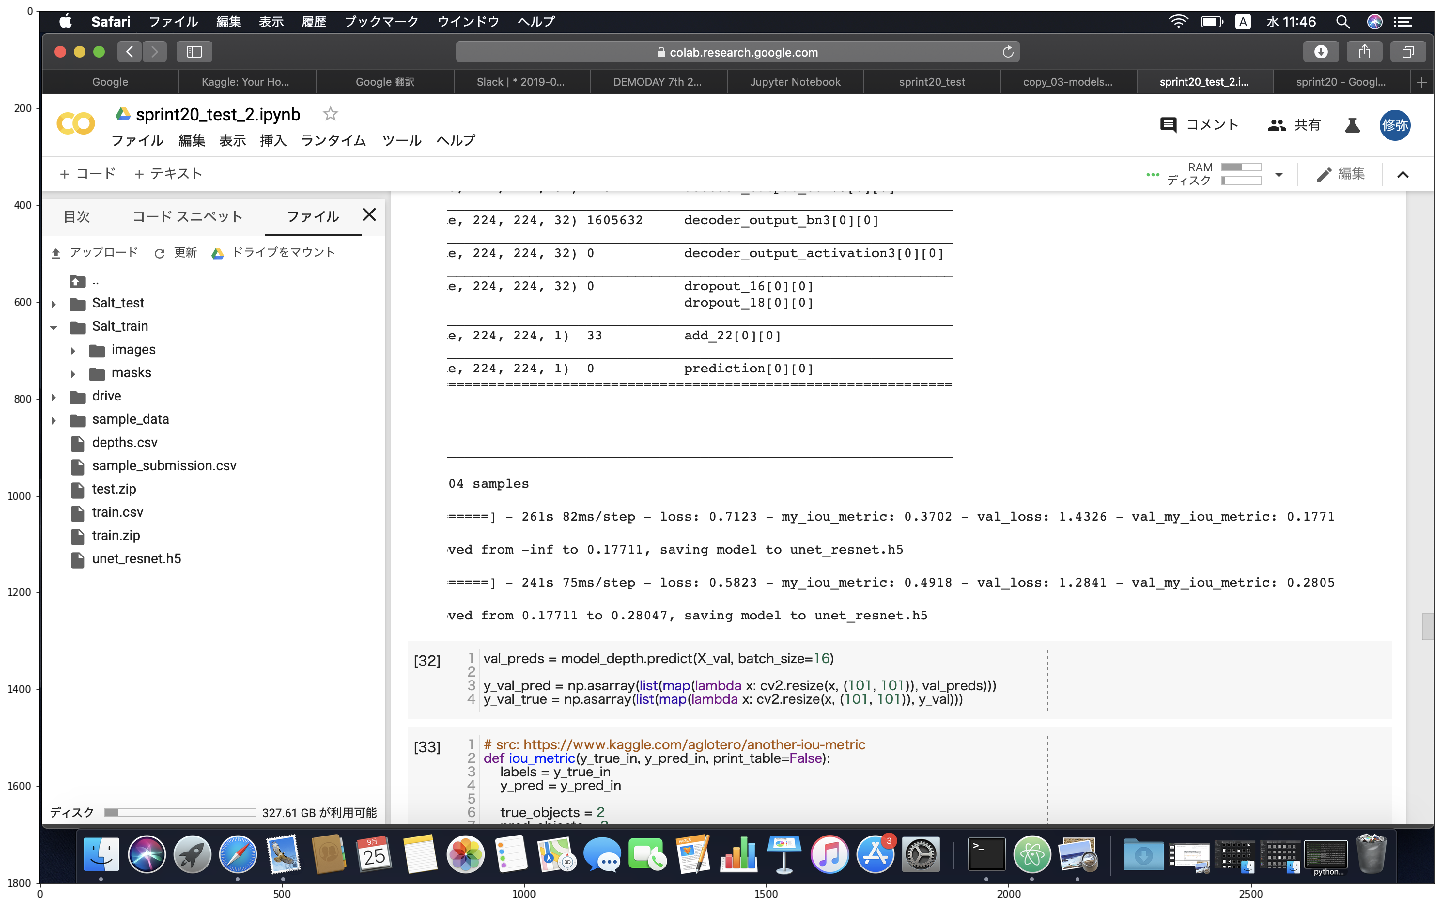

In [5]:
im = Image.open("./resnet_metrics.png")
im_list = np.asarray(im)
plt.figure(figsize=(25, 25))
plt.imshow(im_list)
plt.show()

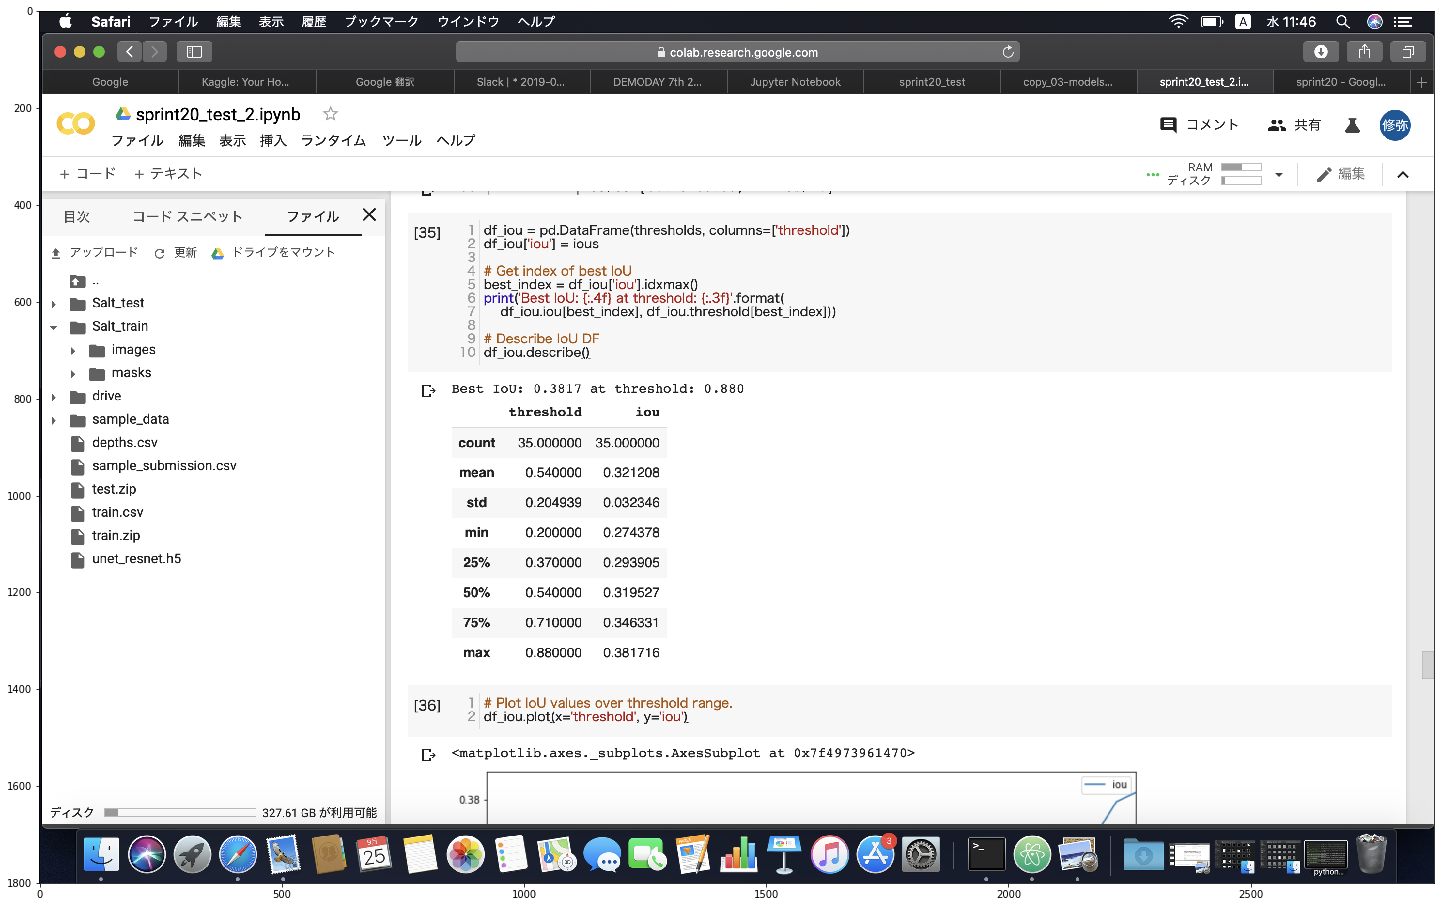

In [10]:
im = Image.open("./resnet_df.png")
im_list = np.asarray(im)
plt.figure(figsize=(25, 25))
plt.imshow(im_list)
plt.show()

## VGGの結果

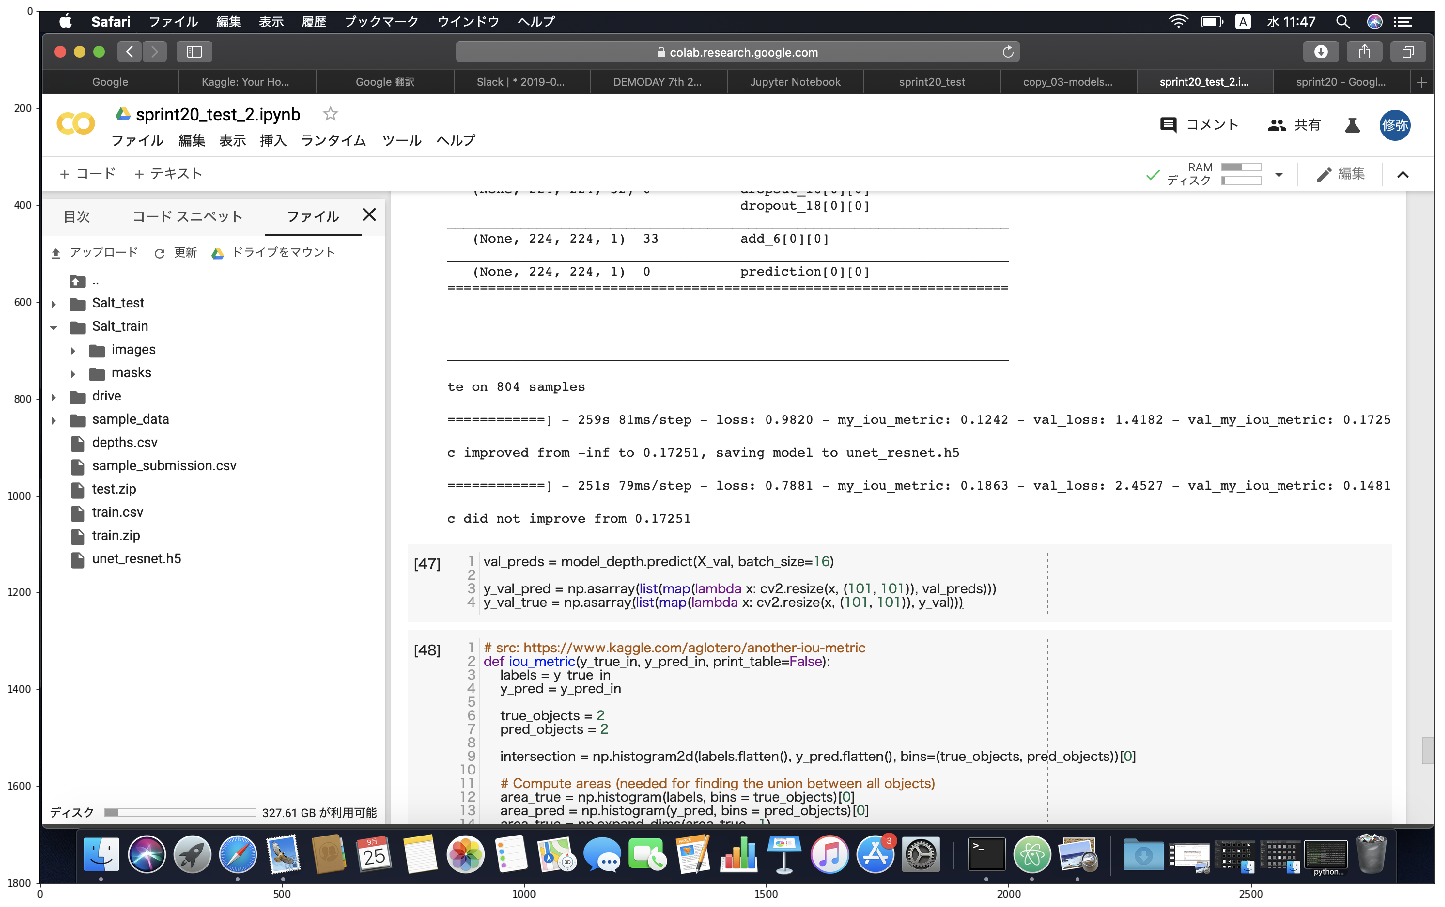

In [11]:
im = Image.open("./vgg_metrics.png")
im_list = np.asarray(im)
plt.figure(figsize=(25, 25))
plt.imshow(im_list)
plt.show()

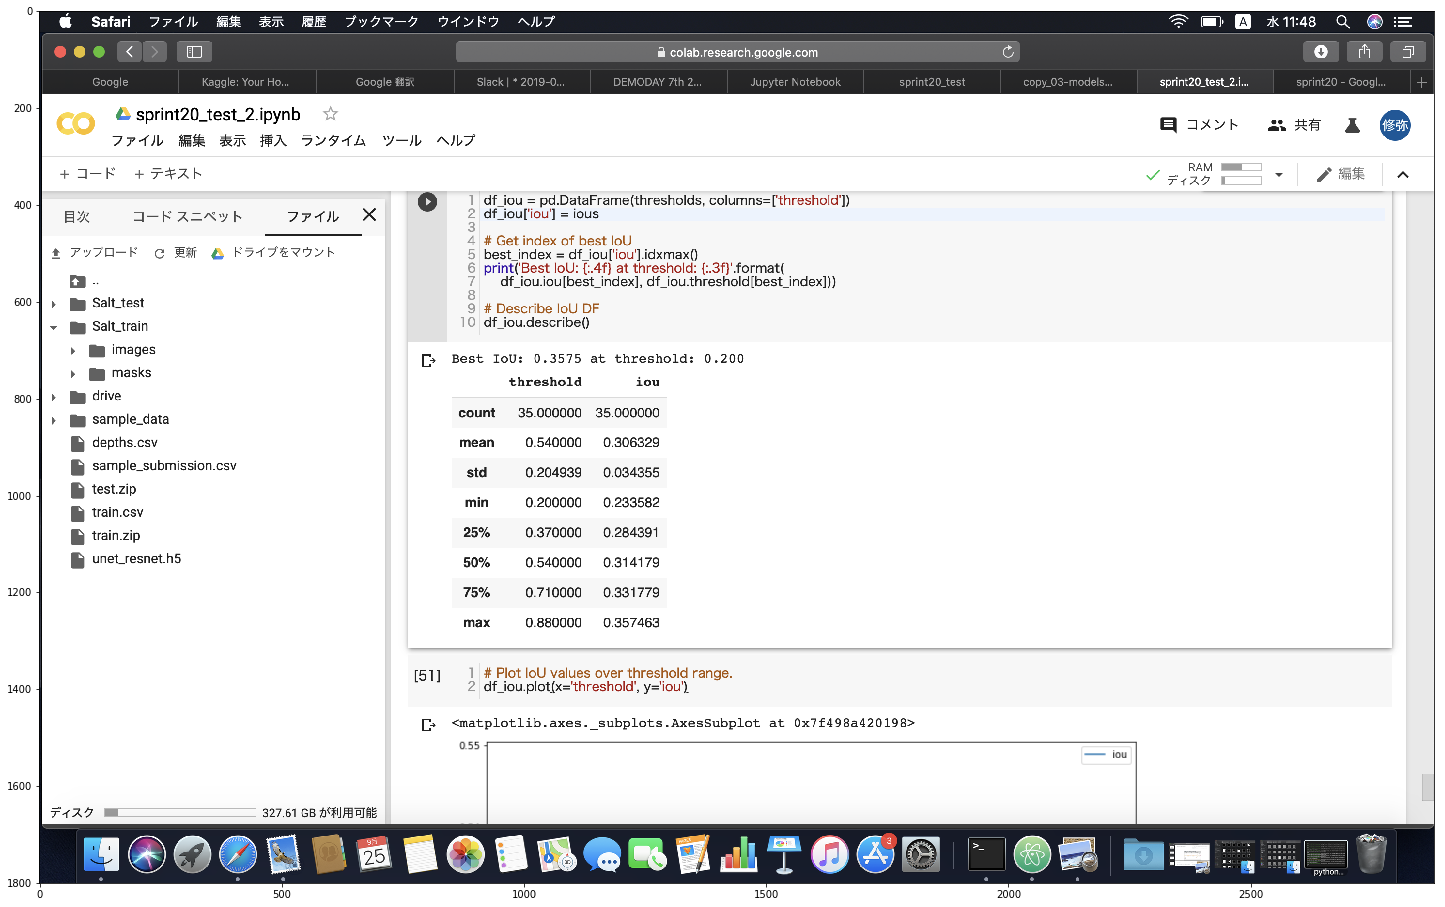

In [12]:
im = Image.open("./vgg_df.png")
im_list = np.asarray(im)
plt.figure(figsize=(25, 25))
plt.imshow(im_list)
plt.show()

## まとめ  (画像中の左が正解ラベル、右が予測値です）

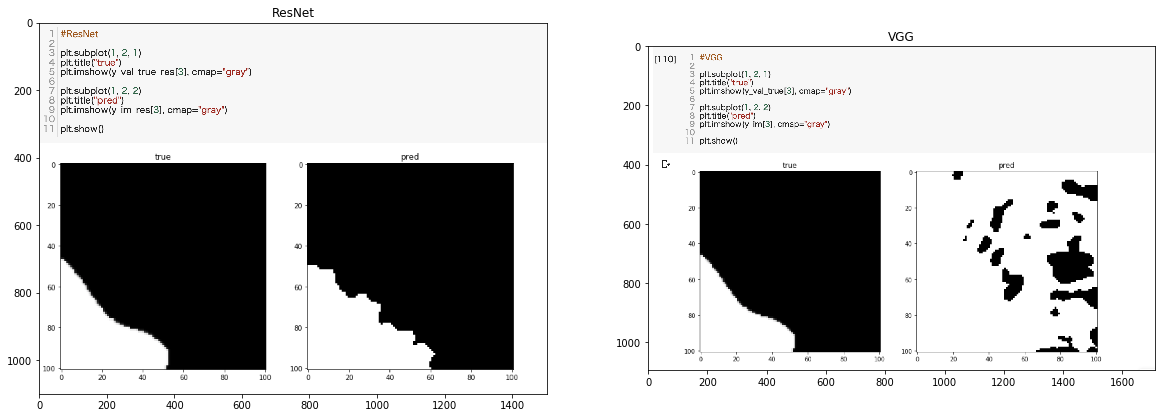

In [35]:
im1 = Image.open("./result_pic_vgg_resize.png")
im_list1 = np.asarray(im1)

im2 = Image.open("./result_pic_res_resize.png")
im_list2 = np.asarray(im2)

plt.figure(figsize=((20, 12)))
plt.subplot(1, 2, 2)
plt.title("VGG")
plt.imshow(im_list1)

plt.subplot(1, 2, 1)
plt.title("ResNet")
plt.imshow(im_list2)

plt.show()

ResNetの方が正解ラベルに近い

In [15]:
result = pd.DataFrame({"loss": [0.5823, 0.7881],
                       "val_iou":[0.2805, 0.1481]},
                     index = ["resnet", "vgg16"])

In [16]:
result

,loss,val_iou
resnet,0.5823,0.2805
vgg16,0.7881,0.1481


VGGよりもResNetの方がlossが小さくiouが高かった  
学習は最後の出力層のみで行ったが、体感的に学習時間にそれほど大きな差はなかったように思える  

epoch数を変えたりして検証してみる必要があるかもしれないが、現時点ではresnetの方が優秀だと考えられる。